In [2]:
#Importing libraries and loading dataset
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

                            
dataset = pd.read_csv('Kathmandu.csv',index_col=0)                            

In [3]:
dataset.head()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
date_and_time,,,,,,
1/1/2019 0:00,98,0.000,4.0,1019.6,-0.7,0.0
1/1/2019 1:00,114,0.000,5.4,1020.5,-0.7,0.0
1/1/2019 2:00,136,0.001,6.4,1021.4,0.0,0.0
1/1/2019 3:00,177,0.004,10.0,1022.2,2.2,0.0
1/1/2019 4:00,195,0.019,12.9,1022.4,-0.4,0.0


In [4]:
# load dataset
df = pd.read_csv('Kathmandu.csv', header=0, index_col=0)
df.describe()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
count,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000
mean,46.098730,0.028960,17.341011,1011.629514,13.298822,0.383567
std,45.102525,0.021166,5.574718,5.699624,6.173613,1.453118
min,1.000000,0.000000,2.400000,997.200000,-8.600000,0.000000
25%,19.000000,0.012000,13.400000,1007.000000,7.800000,0.000000
50%,37.000000,0.025000,18.400000,1012.400000,14.200000,0.000000
75%,61.000000,0.042000,21.400000,1016.300000,19.100000,0.100000
max,985.000000,0.118000,29.000000,1024.700000,23.900000,30.300000


In [5]:
dataset_columns = df.columns.tolist()
dataset_columns

['PM2.5', 'O3', 'TEMPERATURE', 'PRESSURE', 'DEWPOINT', 'RAIN']

In [6]:
import numpy as np

mean_pm = df['PM2.5'].mean()
std_pm = df['PM2.5'].std()
z_scores = (df['PM2.5'] - mean_pm) / std_pm

threshold = 3
df = df[np.abs(z_scores) < threshold]

In [7]:
# from sklearn.preprocessing import LabelEncoder

# # Encode non categorical values
# values = df.values
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# values = values.astype('float32')
# values[:,4]

In [7]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_dataset = scaler.fit_transform(values)
scaled_dataset = scaler.fit_transform(df)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Assuming the PM2.5 values are in index 1, and the rest are features
# X = values[:, [0] + list(range(2, values.shape[1]))]  # Features (all columns except index 1)
# y = values[:, 1]        # Target (PM2.5 values, column at index 1)

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))

# # Normalize the feature set (X)
# X_scaled = scaler.fit_transform(X)

# # Normalize the target variable (y)
# y_scaled = scaler.fit_transform(y.reshape(-1, 1))  # Reshape y to 2D for scaling

# # Now you have X_scaled and y_scaled, both normalized


In [8]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 2
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [9]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)


Y (7564, 1)
X (7564, 2, 6)


In [10]:
from sklearn.model_selection import train_test_split


# Step 1: First, split into training and testing sets (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Check the shapes of the splits
print("X_train shape after first split:", X_train.shape)
print("X_test shape after first split:", X_test.shape)

# Step 2: Split the training data further into training and validation sets
# 80% of the training data for training and 20% of it for validation
n_val = int(X_train.shape[0] * 0.2)  # 20% for validation from the training data

# Manually create validation and training data by slicing the X_train and y_train
X_val, X_train = X_train[:n_val], X_train[n_val:]
y_val, y_train = y_train[:n_val], y_train[n_val:]

# Check the shapes of the final splits
print("X_train shape after final split:", X_train.shape)
print("X_val shape after final split:", X_val.shape)
print("X_test shape after final split:", X_test.shape)

print("y_train shape after final split:", y_train.shape)
print("y_val shape after final split:", y_val.shape)
print("y_test shape after final split:", y_test.shape)


X_train shape after first split: (6051, 2, 6)
X_test shape after first split: (1513, 2, 6)
X_train shape after final split: (4841, 2, 6)
X_val shape after final split: (1210, 2, 6)
X_test shape after final split: (1513, 2, 6)
y_train shape after final split: (4841, 1)
y_val shape after final split: (1210, 1)
y_test shape after final split: (1513, 1)


In [11]:
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import keras_tuner as kt
import numpy as np

# Ensure n_steps and n_features are defined
n_steps = X_train.shape[1]  # Define number of time steps
n_features = 6  # Example feature count (update accordingly)

# Define hyperparameter tuning function
def build_model(hp):
    model = Sequential()
    
    # Single LSTM layer with tuning of units
    model.add(LSTM(
        units=hp.Choice('units', [8, 16, 32, 64, 128]),  # Tuning hidden units
        activation='relu',
        input_shape=(n_steps, n_features)
    ))
    
    # Dropout layer with tuning of dropout rate
    model.add(Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])))  # Tuning dropout rate
    
    # Output layer
    model.add(Dense(1))  # Regression output
    
    # Optimizer Selection with different learning rates
    optimizer_choice = hp.Choice('optimizer', ['SGD', 'Adam', 'RMSprop'])  # Tuning optimizer
    
    if optimizer_choice == 'SGD':
        optimizer = SGD(
            learning_rate=hp.Choice('sgd_lr', [0.01, 0.005, 0.001, 0.0005]),  # Tuning SGD learning rate
            momentum=0.9, nesterov=True
        )
    elif optimizer_choice == 'Adam':
        optimizer = Adam(
            learning_rate=hp.Choice('adam_lr', [0.001, 0.0005, 0.0001, 0.00005])  # Tuning Adam learning rate
        )
    else:  # RMSprop
        optimizer = RMSprop(
            learning_rate=hp.Choice('rmsprop_lr', [0.001, 0.0005, 0.0001, 0.00005]),  # Tuning RMSprop learning rate
            rho=0.9
        )
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='loss',  # Tuning for minimum loss
    max_trials=10,  # Number of trials for hyperparameter search
    executions_per_trial=1,  # Number of times each trial is executed
    directory='kt_tuning',  # Directory for storing tuning results
    project_name='lstm_aqi_tuning_v2'  # Project name for storing results
)

# Perform Hyperparameter Search (ensure you have validation data like X_split_val, y_split_val)
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Output the best hyperparameters
print(f"""
Best LSTM units: {best_hps.get('units')}
Best Dropout Rate: {best_hps.get('dropout')}
Best Optimizer: {best_hps.get('optimizer')}
Best Learning Rate: {best_hps.get('sgd_lr' if best_hps.get('optimizer') == 'SGD' else 'adam_lr' if best_hps.get('optimizer') == 'Adam' else 'rmsprop_lr')}
""")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

Trial 10 Complete [00h 00m 34s]
loss: 0.004168889485299587

Best loss So Far: 0.0034866787027567625
Total elapsed time: 00h 03m 41s

Best LSTM units: 128
Best Dropout Rate: 0.3
Best Optimizer: Adam
Best Learning Rate: 0.0005

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0252 - mae: 0.1129 - val_loss: 0.0301 - val_mae: 0.1276
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0068 - mae: 0.0564 - val_loss: 0.0230 - val_mae: 0.1096
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057 - mae: 0.0484 - val_loss: 0.0218 - val_mae: 0.1067
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - mae: 0.0460 - val_loss: 0.0206 - val_mae: 0.1042
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - mae: 0.0455 - val_loss: 0.0202 - val_mae: 0.1046
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - mae: 0.0442 - val_loss: 0.0193 - val_mae: 0.1013
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Perform Predictions
y_pred = best_model.predict(X_test)

# Compute MSE, MAE, RMSE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 0.0828360512439248
MSE: 0.0068618113856861365
MAE: 0.05984548669815361
R²: 0.691685202667923


In [25]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse, cv_mae, cv_rmse = [], [], []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Train model on fold
    fold_model = tuner.hypermodel.build(best_hps)
    fold_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

    # Predict
    y_val_pred = fold_model.predict(X_val_fold)

    # Compute Metrics
    fold_mse = mean_squared_error(y_val_fold, y_val_pred)
    fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    fold_rmse = np.sqrt(fold_mse)

    cv_mse.append(fold_mse)
    cv_mae.append(fold_mae)
    cv_rmse.append(fold_rmse)

# Print Cross Validation Results
# print(f"Cross-Validation MSE: {np.mean(cv_mse)} ± {np.std(cv_mse)}")
# print(f"Cross-Validation MAE: {np.mean(cv_mae)} ± {np.std(cv_mae)}")
# print(f"Cross-Validation RMSE: {np.mean(cv_rmse)} ± {np.std(cv_rmse)}")

print(f"Cross-Validation MSE: {np.mean(cv_mse)} (std: {np.std(cv_mse)})")
print(f"Cross-Validation MAE: {np.mean(cv_mae)} (std: {np.std(cv_mae)})")
print(f"Cross-Validation RMSE: {np.mean(cv_rmse)} (std: {np.std(cv_rmse)})")


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Cross-Validation MSE: 0.003364405397953377 (std: 0.0005402682224512552)
Cross-Validation MAE: 0.035123011883614656 (std: 0.0014732223126966584)
Cross-Validation RMSE: 0.057824074675477025 (std: 0.004558704407859109)


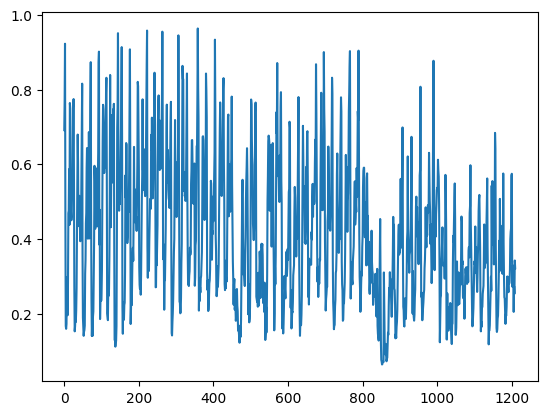

In [26]:
plt.plot(y_pred)

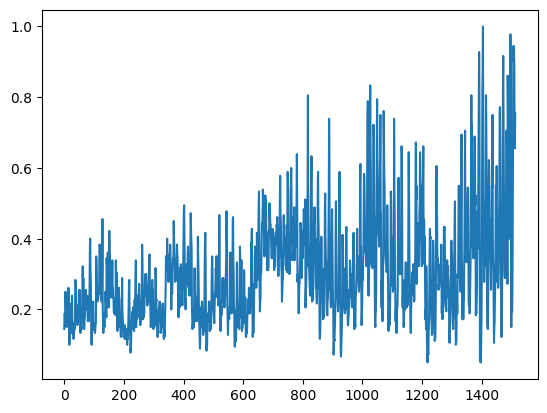

In [27]:
plt.plot(y_test)

In [28]:
_, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.03581, Test: 0.05985


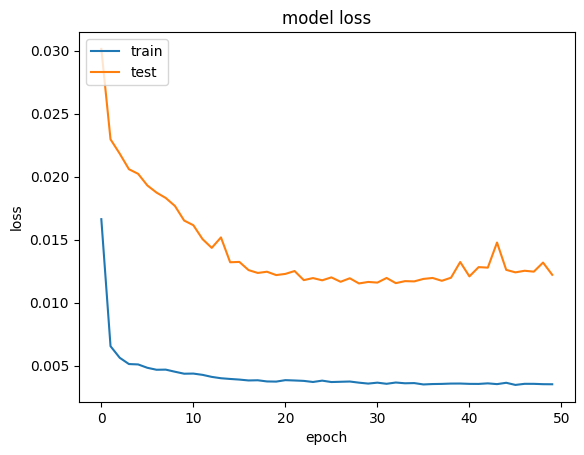

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

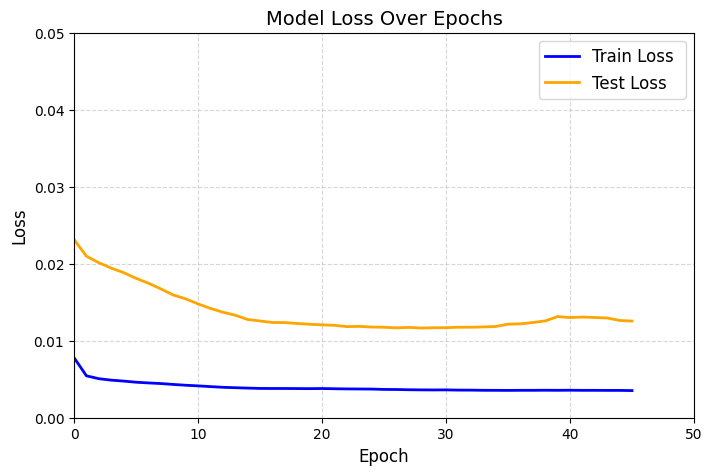

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply smoothing to the validation loss
val_loss_smooth = moving_average(history.history['val_loss'], window_size=5)
train_loss_smooth = moving_average(history.history['loss'], window_size=5)

# Plot the smoothed loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_smooth, label='Train Loss ', color='blue', linewidth=2)
plt.plot(val_loss_smooth, label='Test Loss', color='orange', linewidth=2)

# Improve readability
plt.title('Model Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlim(0, 50)
plt.ylim(0, 0.05)  # Adjust y-axis if needed
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


Epoch-wise validation loss:
Epoch 1: 0.030131952837109566
Epoch 2: 0.02295776642858982
Epoch 3: 0.021819693967700005
Epoch 4: 0.020586030557751656
Epoch 5: 0.02021964266896248
Epoch 6: 0.019298164173960686
Epoch 7: 0.01873168721795082
Epoch 8: 0.018303459510207176
Epoch 9: 0.017669303342700005
Epoch 10: 0.016512425616383553
Epoch 11: 0.016141671687364578
Epoch 12: 0.015037872828543186
Epoch 13: 0.014343268238008022
Epoch 14: 0.01517494022846222
Epoch 15: 0.013202101923525333
Epoch 16: 0.01322967279702425
Epoch 17: 0.012579605914652348
Epoch 18: 0.012353493832051754
Epoch 19: 0.012450897134840488
Epoch 20: 0.012184630148112774
Epoch 21: 0.012277773581445217
Epoch 22: 0.012505998834967613
Epoch 23: 0.01178391557186842
Epoch 24: 0.011946660466492176
Epoch 25: 0.011769408360123634
Epoch 26: 0.012002288363873959
Epoch 27: 0.0116523876786232
Epoch 28: 0.011932498775422573
Epoch 29: 0.01152021437883377
Epoch 30: 0.011640322394669056
Epoch 31: 0.011587762273848057
Epoch 32: 0.01195637974888086

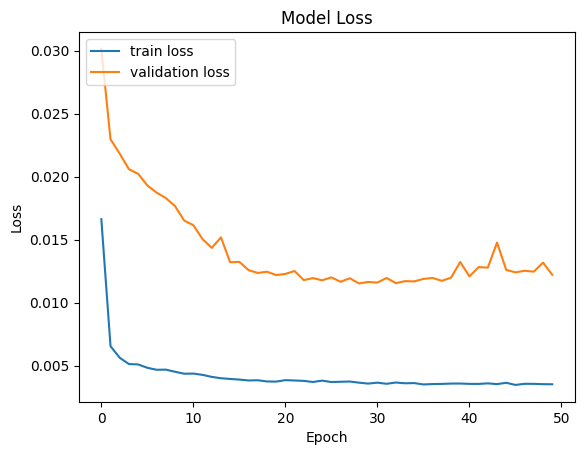

In [19]:
# Print validation loss at each epoch
print("Epoch-wise validation loss:")
for epoch, val_loss in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1}: {val_loss}")

# Plotting the loss graph
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Epoch-wise validation loss:
Epoch 1: 0.030131952837109566
Epoch 2: 0.02295776642858982
Epoch 3: 0.021819693967700005
Epoch 4: 0.020586030557751656
Epoch 5: 0.02021964266896248
Epoch 6: 0.019298164173960686
Epoch 7: 0.01873168721795082
Epoch 8: 0.018303459510207176
Epoch 9: 0.017669303342700005
Epoch 10: 0.016512425616383553
Epoch 11: 0.016141671687364578
Epoch 12: 0.015037872828543186
Epoch 13: 0.014343268238008022
Epoch 14: 0.01517494022846222
Epoch 15: 0.013202101923525333
Epoch 16: 0.01322967279702425
Epoch 17: 0.012579605914652348
Epoch 18: 0.012353493832051754
Epoch 19: 0.012450897134840488
Epoch 20: 0.012184630148112774
Epoch 21: 0.012277773581445217
Epoch 22: 0.012505998834967613
Epoch 23: 0.01178391557186842
Epoch 24: 0.011946660466492176
Epoch 25: 0.011769408360123634
Epoch 26: 0.012002288363873959
Epoch 27: 0.0116523876786232
Epoch 28: 0.011932498775422573
Epoch 29: 0.01152021437883377
Epoch 30: 0.011640322394669056
Epoch 31: 0.011587762273848057
Epoch 32: 0.01195637974888086

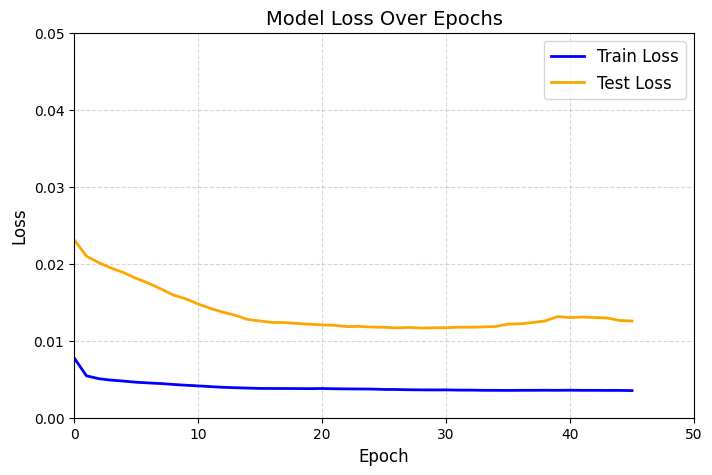

In [31]:
# Print validation loss at each epoch
print("Epoch-wise validation loss:")
for epoch, val_loss in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1}: {val_loss}")

import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply smoothing to the validation loss
val_loss_smooth = moving_average(history.history['val_loss'], window_size=5)
train_loss_smooth = moving_average(history.history['loss'], window_size=5)

# Plot the smoothed loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_smooth, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_loss_smooth, label='Test Loss', color='orange', linewidth=2)

# Improve readability
plt.title('Model Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlim(0, 50)
plt.ylim(0, 0.05)  # Adjust y-axis if needed
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


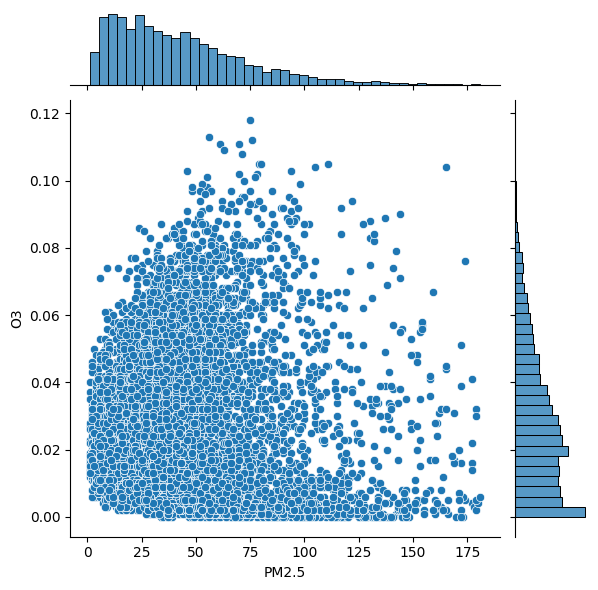

In [32]:
import seaborn as sns
sns.jointplot(x=df['PM2.5'], y=df['O3'], data = df)

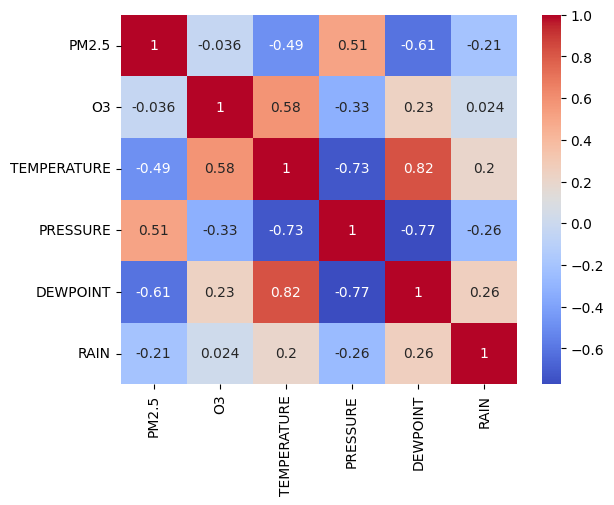

In [33]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

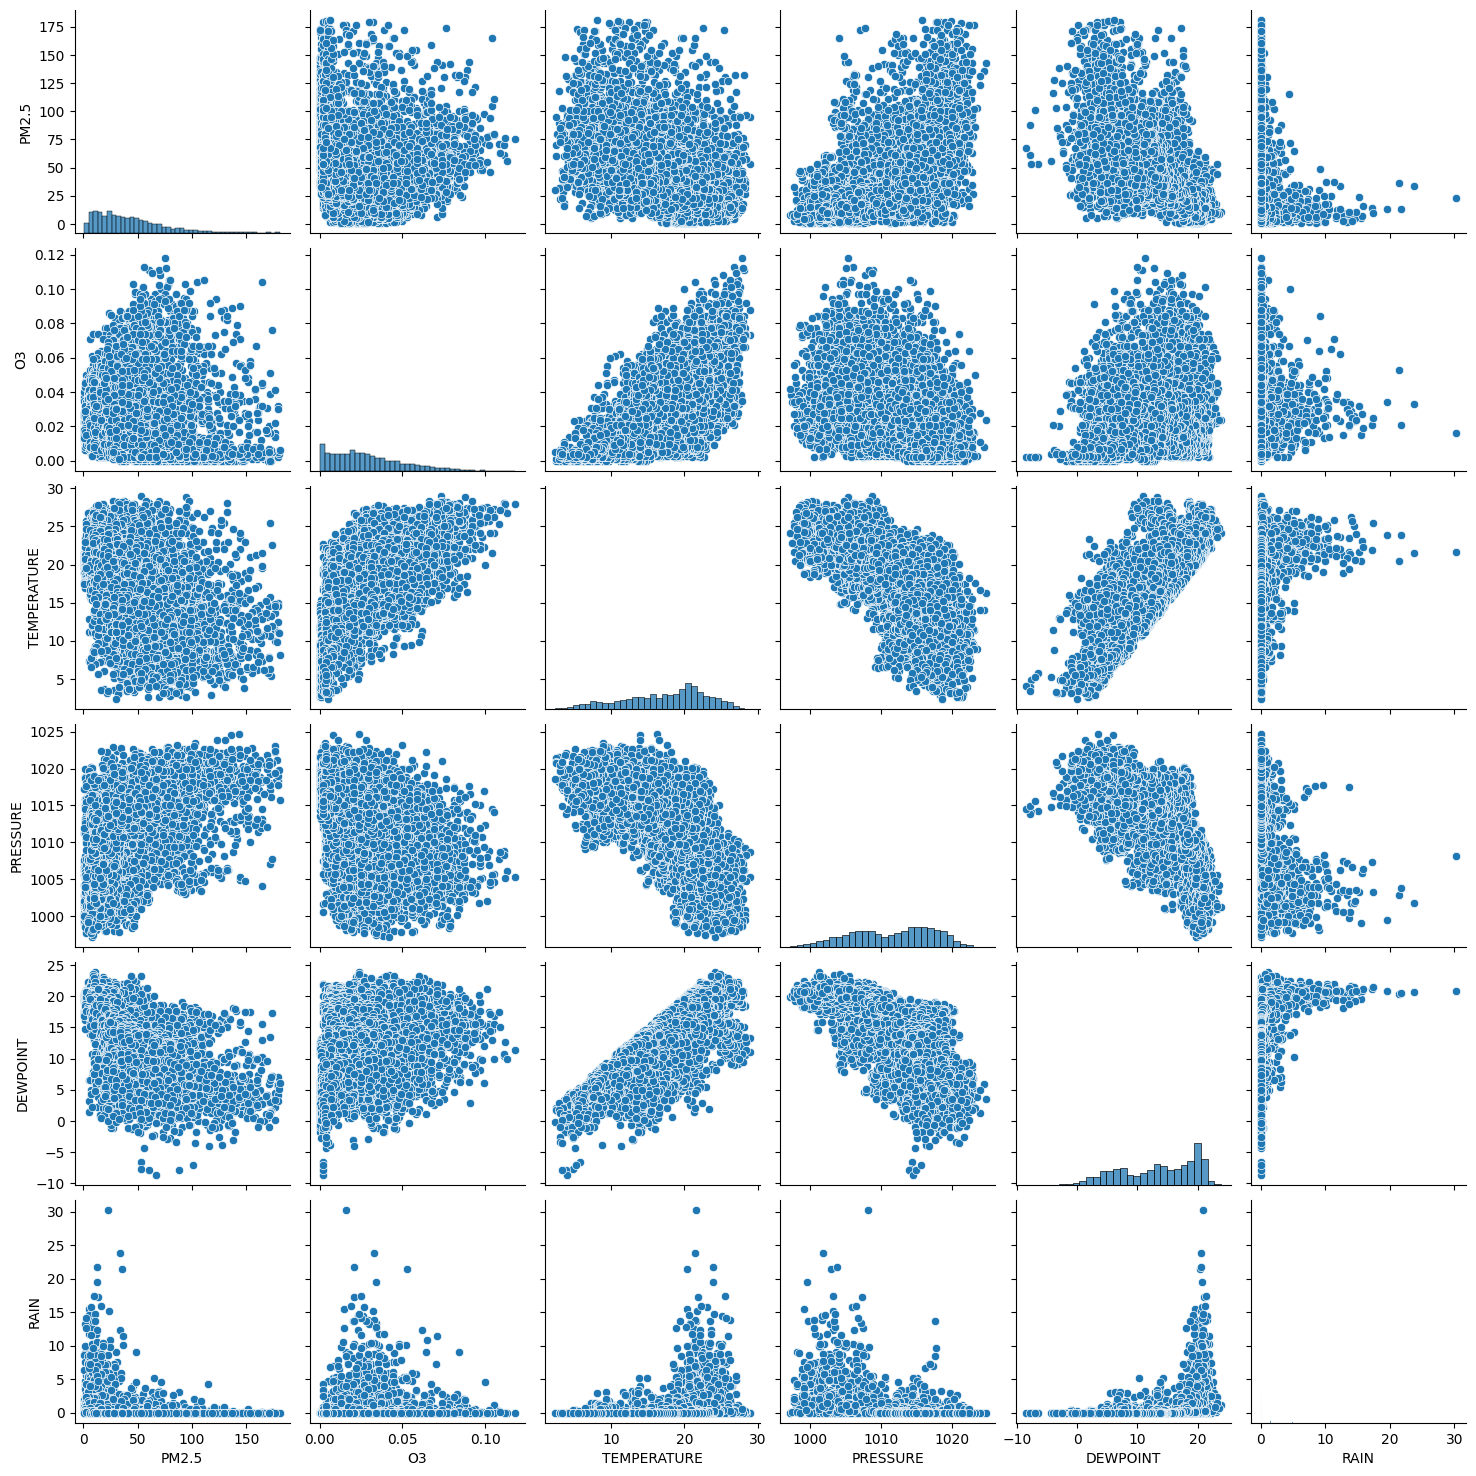

In [34]:
g = sns.pairplot(df)

In [25]:
# df.plot.scatter(x='PM2.5', y='O3', c='DarkBlue')

In [26]:
# # Assuming you have arrays y_pred and y_observed
# # y_pred and y_observed should have the same length
# y_pred = best_model.predict(X).flatten()
# y_observed = Y
# plt.figure(figsize=(8, 8))
# plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
# plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
# plt.title('Transformer')
# plt.xlabel('Observed Flow')
# plt.ylabel('Predicted Flow')
# plt.grid(True)
# plt.show()

In [27]:
# import numpy as np
# import matplotlib.pyplot as plt

# def forecast_future_lstm(best_model, last_window, scaler, days=10):
#     """
#     Predict future values using an LSTM model based on the last available data.

#     best_model: Trained LSTM model
#     last_window: Last `window_size` observations (shape: (1, window_size, n_features))
#     scaler: The MinMaxScaler used during training
#     days: Number of future days to predict
#     """
#     future_predictions = []
#     current_input = last_window.copy()  # Start with the last known data

#     for _ in range(days):
#         # Predict next step
#         predicted_value = best_model.predict(current_input, verbose=0)
        
#         # Save the predicted value
#         future_predictions.append(predicted_value[0, 0])  # Assuming single-step forecast

#         # Create a placeholder for the new feature vector (same number of features)
#         new_feature_vector = np.zeros((1, 1, current_input.shape[2]))  # Shape: (1,1,n_features)
#         new_feature_vector[0, 0, 0] = predicted_value[0, 0]  # Assign predicted value to first feature

#         # Shift window by appending the new prediction
#         current_input = np.concatenate((current_input[:, 1:, :], new_feature_vector), axis=1)

#     # Convert list to numpy array
#     future_predictions = np.array(future_predictions).reshape(-1, 1)

#     # Create a placeholder with 6 features (same shape as original data)
#     future_predictions_expanded = np.zeros((len(future_predictions), 6))  
#     future_predictions_expanded[:, 0] = future_predictions[:, 0]  # Place predictions in first column

#     # Apply inverse transform using the original scaler
#     future_predictions = scaler.inverse_transform(future_predictions_expanded)[:, 0]  # Extract only the first column

#     return future_predictions


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


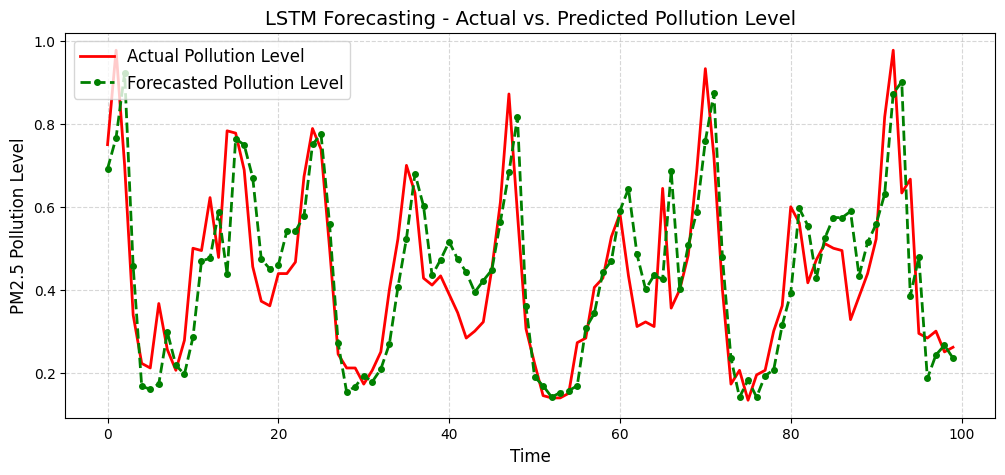

In [42]:
y_pred = best_model.predict(X_val)

# Plot actual vs. predicted values
plt.figure(figsize=(12, 5))
plt.plot(y_val[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')
# plt.axvspan(len(y_test[:90]), len(y_test[:100]), color='green', alpha=0.2, label="Forecasted Region")

plt.title("LSTM Forecasting - Actual vs. Predicted Pollution Level", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [28]:
# correlations = df.corr()
# fig, ax = plt.subplots(figsize=(15,15))
# sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
# plt.show();

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

C:\Users\Acer\AppData\Local\Temp\ipykernel_7232\843569222.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


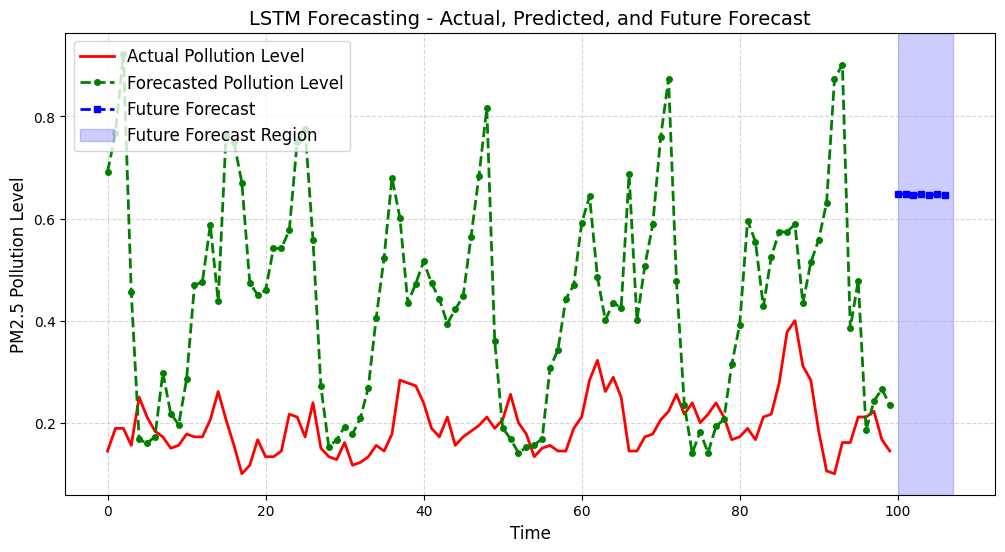

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of future days to predict
future_days = 7

# Get the last time steps from the test set as input for forecasting
input_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])  # Reshape to match LSTM input

# Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

# Convert predictions to numpy array
future_predictions = np.array(future_predictions)

# Plot actual vs. predicted with future forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')

# Extend time axis for future predictions
future_time = np.arange(len(y_test[:100]), len(y_test[:100]) + future_days)

# Plot future forecasted values
plt.plot(future_time, future_predictions, color='blue', linestyle='dashed', linewidth=2, marker='s', markersize=5, label='Future Forecast')

# Highlight the forecasted region
plt.axvspan(len(y_test[:100]), len(y_test[:100]) + future_days, color='blue', alpha=0.2, label="Future Forecast Region")

# Improve labels and title
plt.title("LSTM Forecasting - Actual, Predicted, and Future Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()


In [27]:
import numpy as np

# Define the number of future days to predict
future_days = 7

# Get the last time steps from the test set as input for forecasting
input_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])  # Reshape to match LSTM input

# Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

# Convert predictions to numpy array
future_predictions = np.array(future_predictions)

# Print forecasted values
print("Forecasted PM2.5 values for the next 7 days:", future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\Acer\AppData\Local\Temp\ipykernel_11004\2791167619.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Forecasted PM2.5 values for the next 7 days: [0.6289282  0.6054477  0.5854459  0.5690878  0.55502814 0.5435558
 0.5335097 ]


In [37]:
# import numpy as np

# # Define the number of future days to predict
# future_days = 7

# # Get the last time steps from the test set as input for forecasting
# input_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])  # Reshape to match LSTM input

# # Store predictions
# future_predictions = []

# for _ in range(future_days):
#     next_pred = best_model.predict(input_data)  # Predict next time step
#     future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

#     # Update input data by shifting and adding new prediction
#     input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
#     input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

# # Convert predictions to numpy array
# future_predictions = np.array(future_predictions).reshape(-1, 1)  # Reshape for inverse transformation
# # future_predictions_actual = scaler.inverse_transform(
# #     np.concatenate([future_predictions, np.zeros((future_predictions.shape[0], df.shape[1] - 1))], axis=1)
# # )[:, 1] 
# # Inverse transform to get actual PM2.5 values
# future_predictions_actual = scaler.inverse_transform(future_predictions)  # Assuming 'scaler_y' was used for PM2.5 during training

# # Print forecasted values
# print("Forecasted PM2.5 values for the next 7 days (Actual Scale):", future_predictions_actual.flatten())


In [28]:
# Convert predictions to numpy array
future_predictions = np.array(future_predictions).reshape(-1, 1)  # Shape (7, 1)

# Assuming that you have 6 features in the original dataset, create a zero-filled array
# for the remaining features (5 zeros in this case since 1 is for PM2.5).
future_predictions_with_zeros = np.concatenate([future_predictions, np.zeros((future_predictions.shape[0], df.shape[1] - 1))], axis=1)

# Inverse transform to get actual PM2.5 values
future_predictions_actual = scaler.inverse_transform(future_predictions_with_zeros)[:, 0]  # Only take the first column (PM2.5)

# Print forecasted values
print("Forecasted PM2.5 values for the next 7 days (Actual Scale):", future_predictions_actual.flatten())


Forecasted PM2.5 values for the next 7 days (Actual Scale): [114.20707321 109.98058772 106.38025856 103.43580461 100.9050653
  98.84004331  97.0317409 ]


In [29]:
import numpy as np

# Define the number of future days to predict
future_days = 7

# Get the last time steps from the test set as input for forecasting
input_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])  # Reshape to match LSTM input

# Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

# Convert predictions to numpy array
# future_predictions = np.array(future_predictions).reshape(-1, 1)  # Reshape for inverse transformation
# future_predictions_actual = scaler.inverse_transform(
#     np.concatenate([future_predictions, np.zeros((future_predictions.shape[0], df.shape[1] - 1))], axis=1)
# )[:, 1] 
# Inverse transform to get actual PM2.5 values
# future_predictions_actual = scaler.inverse_transform(future_predictions)  # Assuming 'scaler_y' was used for PM2.5 during training

# Print forecasted values
# print("Forecasted PM2.5 values for the next 7 days (Actual Scale):", future_predictions_actual.flatten())

# Convert predictions to numpy array
future_predictions = np.array(future_predictions).reshape(-1, 1)  # Shape (7, 1)

# Assuming that you have 6 features in the original dataset, create a zero-filled array
# for the remaining features (5 zeros in this case since 1 is for PM2.5).
future_predictions_with_zeros = np.concatenate([future_predictions, np.zeros((future_predictions.shape[0], df.shape[1] - 1))], axis=1)

# Inverse transform to get actual PM2.5 values
future_predictions_actual = scaler.inverse_transform(future_predictions_with_zeros)[:, 0]  # Only take the first column (PM2.5)

# Print forecasted values
print("Forecasted PM2.5 values for the next 7 days (Actual Scale):", future_predictions_actual.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\Acer\AppData\Local\Temp\ipykernel_11004\2263803491.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Forecasted PM2.5 values for the next 7 days (Actual Scale): [114.20707321 109.98058772 106.38025856 103.43580461 100.9050653
  98.84004331  97.0317409 ]


Forecast for 7 days in the future

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


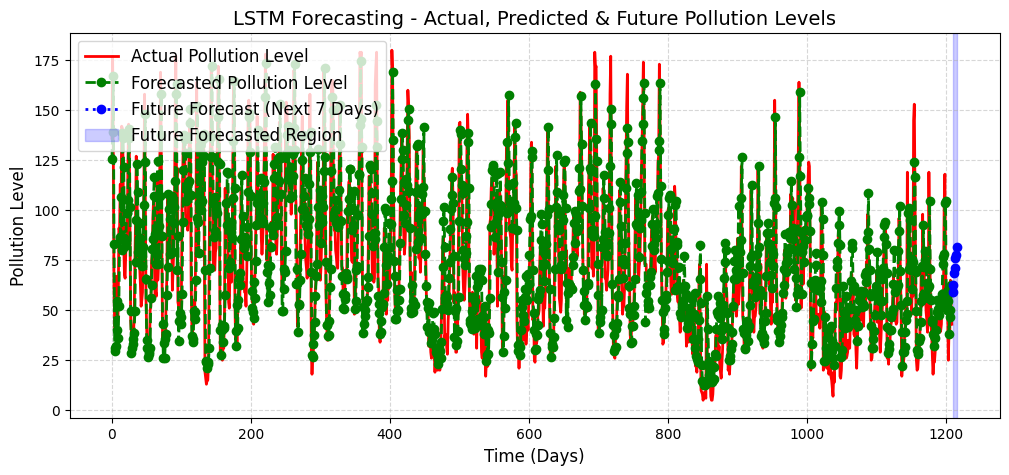

In [37]:
import numpy as np

import matplotlib.pyplot as plt

# Number of days to forecast
n_future = 7

# List to store future forecasted values
future_forecast = []

# Start with the last available input sequence
input_sequence = X_val[-1]  # Last known sequence from validation data

for _ in range(n_future):
  # Predict next step
  prediction = best_model.predict(input_sequence.reshape(1, input_sequence.shape[0], input_sequence.shape[1]))[0, 0]
  future_forecast.append(prediction)
  
  # Update input_sequence by shifting & appending the new prediction
  input_sequence = np.roll(input_sequence, -1, axis=0)
  input_sequence[-1, 0] = prediction  # Replace the last value with the new forecast

# Convert future_forecast back to original scale
future_forecast = np.array(future_forecast).reshape(-1, 1)  # Ensure correct shape
future_forecast = scaler.inverse_transform(np.concatenate([future_forecast, np.zeros((n_future, X.shape[2] - 1))], axis=1))[:, 0]

# Convert actual and predicted values back to original scale
y_val_original = scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), X.shape[2] - 1))], axis=1))[:, 0]
y_pred_original = scaler.inverse_transform(np.concatenate([y_pred.reshape(-1, 1), np.zeros((len(y_pred), X.shape[2] - 1))], axis=1))[:, 0]

# Time axis
past_time = np.arange(len(y_val))  # Past actual data points
future_time = np.arange(len(y_val), len(y_val) + n_future)  # Future forecasted points

# Plot actual vs. predicted vs. future forecast
plt.figure(figsize=(12, 5))

# Actual pollution level (red solid)
plt.plot(past_time, y_val_original, color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')

# Predicted pollution level (green dashed with markers)
plt.plot(past_time, y_pred_original, color='green', linestyle='dashed', linewidth=2, marker='o', label='Forecasted Pollution Level')

# Future forecast (blue dotted with markers)
plt.plot(future_time, future_forecast, color='blue', linestyle='dotted', linewidth=2, marker='o', label='Future Forecast (Next 7 Days)')

# Highlight forecasted region
plt.axvspan(len(y_val), len(y_val) + n_future, color='blue', alpha=0.2, label="Future Forecasted Region")

plt.title("LSTM Forecasting - Actual, Predicted & Future Pollution Levels", fontsize=14)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Pollution Level", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


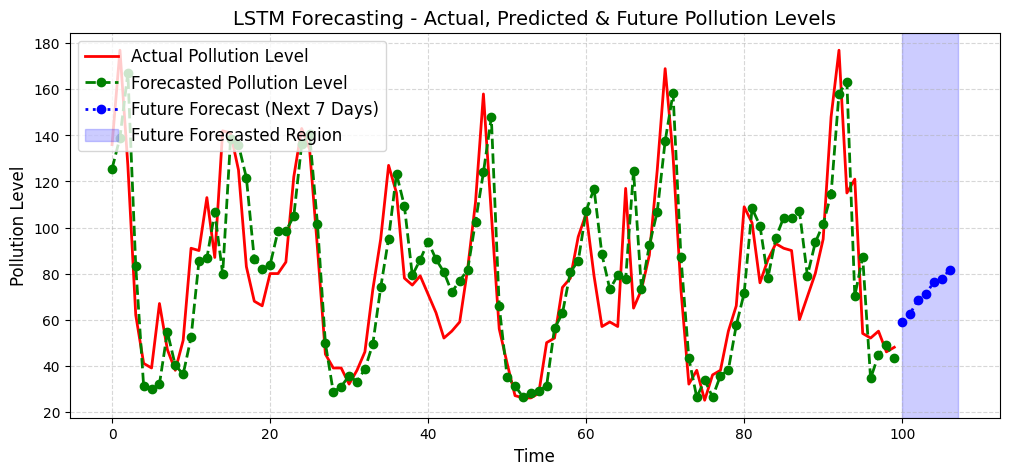

In [38]:
# Number of days to forecast
n_future = 7

# List to store future forecasted values
future_forecast = []

# Start with the last available input sequence
input_sequence = X_val[-1]  # Last known sequence from validation data

for _ in range(n_future):
  # Predict next step
  prediction = best_model.predict(input_sequence.reshape(1, input_sequence.shape[0], input_sequence.shape[1]))[0, 0]
  future_forecast.append(prediction)
  
  # Update input_sequence by shifting & appending the new prediction
  input_sequence = np.roll(input_sequence, -1, axis=0)
  input_sequence[-1, 0] = prediction  # Replace the last value with the new forecast

# Convert future_forecast back to original scale
future_forecast = np.array(future_forecast).reshape(-1, 1)  # Ensure correct shape
future_forecast = scaler.inverse_transform(np.concatenate([future_forecast, np.zeros((n_future, X.shape[2] - 1))], axis=1))[:, 0]

# Convert actual and predicted values back to original scale
y_val_original = scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), X.shape[2] - 1))], axis=1))[:, 0]
y_pred_original = scaler.inverse_transform(np.concatenate([y_pred.reshape(-1, 1), np.zeros((len(y_pred), X.shape[2] - 1))], axis=1))[:, 0]

# Time axis
past_time = np.arange(100)  # Past actual data points (first 100 days)
future_time = np.arange(100, 100 + n_future)  # Future forecasted points

# Plot actual vs. predicted vs. future forecast
plt.figure(figsize=(12, 5))

# Actual pollution level (red solid)
plt.plot(past_time, y_val_original[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')

# Predicted pollution level (green dashed with markers)
plt.plot(past_time, y_pred_original[:100], color='green', linestyle='dashed', linewidth=2, marker='o', label='Forecasted Pollution Level')

# Future forecast (blue dotted with markers)
plt.plot(future_time, future_forecast, color='blue', linestyle='dotted', linewidth=2, marker='o', label='Future Forecast (Next 7 Days)')

# Highlight forecasted region
plt.axvspan(100, 100 + n_future, color='blue', alpha=0.2, label="Future Forecasted Region")

plt.title("LSTM Forecasting - Actual, Predicted & Future Pollution Levels", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Pollution Level", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [1]:
# Print forecasted PM2.5 values for the next 7 days (Actual Scale)
print("Forecasted PM2.5 values for the next 7 days (Actual Scale):", future_forecast)

NameError: name 'future_forecast' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


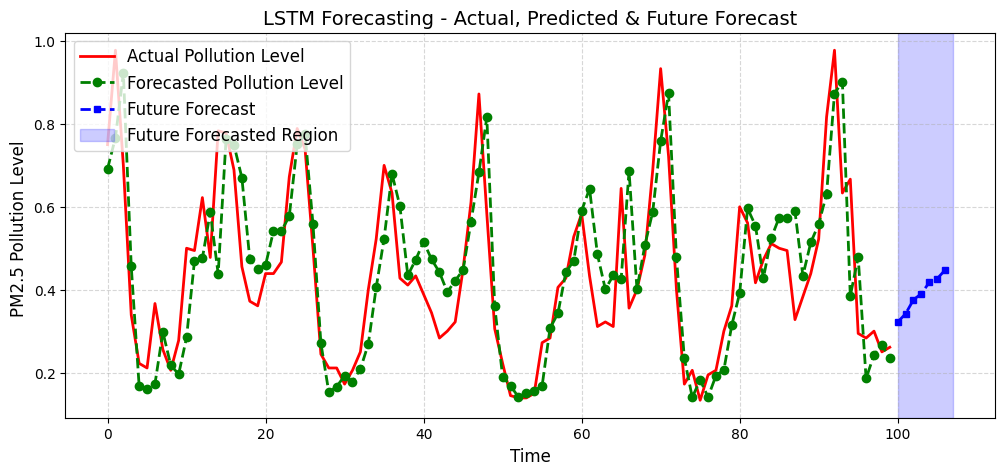

In [43]:
# Number of days to forecast
n_future = 7

# List to store future forecasted values
future_forecast = []

# Start with the last available input sequence
input_sequence = X_val[-1]  # Last known sequence from validation data

for _ in range(n_future):
  # Predict next step
  prediction = best_model.predict(input_sequence.reshape(1, input_sequence.shape[0], input_sequence.shape[1]))[0, 0]
  future_forecast.append(prediction)
  
  # Update input_sequence by shifting & appending the new prediction
  input_sequence = np.roll(input_sequence, -1, axis=0)
  input_sequence[-1, 0] = prediction  # Replace the last value with the new forecast

# Convert future_forecast to numpy array
future_forecast = np.array(future_forecast)

# Time axis
past_time = np.arange(100)  # Past actual data points (first 100 days)
future_time = np.arange(100, 100 + n_future)  # Future forecasted points

# Plot actual vs. predicted vs. future forecast
plt.figure(figsize=(12, 5))

# Actual pollution level (red solid)
plt.plot(past_time, y_val[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')

# Predicted pollution level (green dashed with markers)
plt.plot(past_time, y_pred[:100], color='green', linestyle='dashed', linewidth=2, marker='o', label='Forecasted Pollution Level')

# Future forecast (blue dotted with markers)
plt.plot(future_time, future_forecast, color='blue', linestyle='dashed', linewidth=2, marker='s', markersize =5, label='Future Forecast')

# Highlight forecasted region
plt.axvspan(100, 100 + n_future, color='blue', alpha=0.2, label="Future Forecasted Region")

plt.title("LSTM Forecasting - Actual, Predicted & Future Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level ", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [40]:
# Print forecasted PM2.5 values for the next 7 days (Actual Scale)
print("Forecasted PM2.5 values for the next 7 days (Actual Scale):", future_forecast)

Forecasted PM2.5 values for the next 7 days (Actual Scale): [0.32191914 0.3420348  0.37571838 0.3905644  0.41772056 0.42661056
 0.4475391 ]


In [41]:
# Forecasted PM2.5 values for the next 7 days (Actual Scale)
actual_values = np.array([0.32191914, 0.3420348, 0.37571838, 0.3905644, 0.41772056, 0.42661056, 0.4475391]).reshape(-1, 1)

# Assuming that you have 6 features in the original dataset, create a zero-filled array
# for the remaining features (5 zeros in this case since 1 is for PM2.5).
actual_values_with_zeros = np.concatenate([actual_values, np.zeros((actual_values.shape[0], df.shape[1] - 1))], axis=1)

# Transform to get scaled PM2.5 values
scaled_values = scaler.transform(actual_values_with_zeros)[:, 0]  # Only take the first column (PM2.5)

# Print scaled values
print("Scaled PM2.5 values for the next 7 days:", scaled_values)

Scaled PM2.5 values for the next 7 days: [-0.00376712 -0.00365536 -0.00346823 -0.00338575 -0.00323489 -0.0031855
 -0.00306923]


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
